# FOR THIS  TEST N=16

# Define The Parameters

In [13]:

KEY_TEXT=4
MSG_TEXT=4
C_TEXT=4
LEARNING_RATE=0.0002
BATCH_SIZE=512
m_train=2**(MSG_TEXT)
NUM_BATCH_SIZE=128
MAX_INTERATION=100000
BOB_ONE_BIT_WRONG_THRESH=0.0025
CLIP_VALUE = 1
LOOPS_PER_PRINT = 100   # every 100 loops print one time
#SAVE_PATH="/content/sample_data/adversarial_neural_cryptography_model_and_optimizer"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [308]:
m_train/256

256.0

# PACKAGE USED IN OUR TEST

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import time

# We define the function we want to use to transforme 

In [4]:
def function(x):
  return torch.acos((1-2*x))
  ''' ''' 

def inv_function(y):
  return (1-torch.cos(y))/2

# We define Our Networks for Alice and Bob

In [5]:
class Network(nn.Module):
    '''
    Standard Convolutional layers setup used by Alice and Bob.
    Input: 2N tensor, PlainText+MessageKey(Alice) or CipherText+Key(Bob)
    Output: N tensor, CipherText(Alice) or PlainText(Bob)
    '''
    def __init__(self):
        super(Network,self).__init__()
        self.fc_in =MSG_TEXT + KEY_TEXT
        self.fc_out = KEY_TEXT
        self.l1 = nn.Linear(self.fc_in,self.fc_out,bias=False)

    def forward(self,input):

        inputs = function(input)
        #print("inputs:",inputs)
        out = self.l1(inputs) #requires_grad
        #print("out:",out.requires_grad)
        _out = inv_function(out) #possibly removes requires grad
        #print("_out:",_out.requires_grad)
        #print("out:",_out)
        
        output = _out
        #print('one pass AB', output.size())
        return output


# Function to GEnerate DATA and Plot

In [6]:
def generate_data(batch_size, ptext_size, key_size):
    """
    generate data.
    :param batch_size: batch size, hyper-parameters, in this program BATCH_SIZE is 256
    :param ptext_size: ptext size, hyper-parameters, in this program PTEXT_SIZE is 16
    :param key_size: key's size, hyper-parameters, in this program KEY_SIZE is 16
    :return: ptext and key, in this program size are both [256, 16]
    """
    ptext = torch.randint(0, 2, (batch_size, ptext_size), dtype=torch.float) * 1
    key = torch.randint(0, 2, (batch_size, key_size), dtype=torch.float) * 1
    return ptext, key

In [7]:
def gen_data(n=BATCH_SIZE, msg_len=MSG_TEXT, key_len=KEY_TEXT):
    return (np.random.randint(0, 2, size=(n, msg_len)) * 1), \
           (np.random.randint(0, 2, size=(n, key_len)) * 1)

In [314]:
msg,key=gen_data(512,16,16)

In [315]:
msg[0]

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0])

In [8]:
def plot_wrong( alice_bob_wrong_for_plot):
    """
    plot epoch-wrong picture
    
    :param alice_bob_wrong_for_plot: a list, element is the mean of bob one bit wrong
    :return:
    """
    plt.plot(range(1, len(alice_bob_wrong_for_plot)+1), alice_bob_wrong_for_plot, label='Alice and Bob')
    plt.xlabel("Step")
    plt.ylabel("Decryption AliceAnd Bob")
    plt.title("optimizer_alice_bob_times")
    plt.legend()
    plt.show()

In [317]:
  #alice = Network()
  #bob = Network()
  #alice_bob_reconstruction_error = nn.L1Loss()
  #optimizer_alice = optim.Adam(alice.parameters(), lr=LEARNING_RATE)
  #optimizer_bob = optim.Adam(bob.parameters(), lr=LEARNING_RATE)

In [318]:
#data = gen_data(BATCH_SIZE, MSG_TEXT, KEY_TEXT)
#msg = torch.tensor(data[0], dtype=torch.float)
#key = torch.tensor(data[1], dtype=torch.float)

In [319]:
#msg,key=generate_data(512,16,16)
#alice_input = torch.cat((msg, key), 1)

In [320]:
#ctext= alice(alice_input)

In [321]:
#print(ctext)

In [322]:
#bob_input = torch.cat((ctext, key), 1)


In [323]:
#bob_output = bob(bob_input)

In [324]:
#print(bob_output)

Epoch: 000001 | one epoch time: 0.767 | bob one bit wrong: 0.4790 |


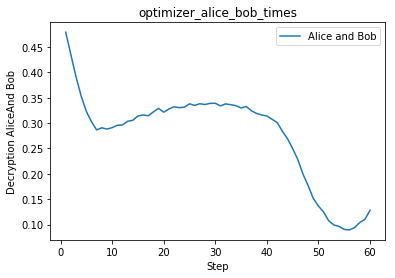

In [326]:
def train():

  alice_bob_one_bit_wrong_mean = 0.0

  alice_bob_wrong_for_plot = []
  #torch.manual_seed(10)
  alice_bob = Network()
  #bob = Network()

  alice_bob.train()
  #bob.train()

  optimizer_alice_bob = optim.Adam(alice_bob.parameters(), lr=LEARNING_RATE)
  #optimizer_bob = optim.Adam(bob.parameters(), lr=LEARNING_RATE)


  alice_bob_reconstruction_error = nn.L1Loss()

  for i in range(60):

    start_time = time.time()

    '''torch.save({
        'Alice_state_dict': alice_bob.state_dict(),
        
        'optimizer_alice_bob_state_dict': optimizer_alice_bob.state_dict(),
         }, SAVE_PATH)'''
    checkpoint={'alice_bob':Network(),
                'state_dict': alice_bob.state_dict(),
                'optimizer': optimizer_alice_bob.state_dict()
                }
    torch.save(checkpoint,'checkpoint.pth')

    #for network,num_minibatch in {'alice_bob': NUM_BATCH_SIZE }.items():

    for minibatch in range(128):
      #np.random.seed(i)
      data = gen_data(BATCH_SIZE, MSG_TEXT, KEY_TEXT)
      msg = torch.tensor(data[0], dtype=torch.float)
      key = torch.tensor(data[1], dtype=torch.float)
      alice_input = torch.cat((msg, key), 1)
      with torch.no_grad():
        ctext= alice_bob(alice_input)
      
      bob_input = torch.cat((ctext, key), 1)
      ptext_bob = alice_bob(bob_input)
      #print(ptext_bob)

      alice_bob_error=alice_bob_reconstruction_error(ptext_bob,msg)
      #print(alice_bob_error)



      #optimizer_alice.zero_grad()
      optimizer_alice_bob.zero_grad()
      alice_bob_error.backward()
      #print(alice_bob_error.grad)
      #print(alice_bob_error)
      nn.utils.clip_grad_value_(alice_bob.parameters(), CLIP_VALUE)
      #nn.utils.clip_grad_value_(bob.parameters(), CLIP_VALUE)


      #optimizer_alice.step()
      optimizer_alice_bob.step()

      time_elapsed = time.time() - start_time

    bob_one_bit_wrong_mean = alice_bob_error.cpu().detach().numpy()
    


    if i % LOOPS_PER_PRINT == 0:
      print(f'Epoch: {i + 1:06d} | '
            f'one epoch time: {time_elapsed:.3f} | '
            f'bob one bit wrong: {bob_one_bit_wrong_mean:.4f} |')
    alice_bob_wrong_for_plot.append(bob_one_bit_wrong_mean)

  plot_wrong(alice_bob_wrong_for_plot)




if __name__ == "__main__":
if
    train()

In [263]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [306]:
2**16/512


128.0

In [10]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['alice_bob']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

#model = load_checkpoint('/content/checkpoint.pth')

In [28]:
import numpy as np

def validate():
    """
    generate a ptext and key and compare them to the output of the model
    :return:
    
    """
    fail=0
    count=0
    for i in range(1):

      data = gen_data(BATCH_SIZE, MSG_TEXT, KEY_TEXT)
      msg = torch.tensor(data[0], dtype=torch.float)
      key = torch.tensor(data[1], dtype=torch.float)

      #alice_bob= model_load_checkpoint()
      alice_bob = load_checkpoint('checkpointv1.pth')
      alice_bob.l1.weight=torch.nn.Parameter(alice_bob.l1.weight.round()) #Not rounded off
      with torch.no_grad():
        ctext = alice_bob(torch.cat((msg, key), 1))

      with torch.no_grad():
        predict_ptext_bob = alice_bob(torch.cat((ctext, key), 1))
    

      # for better print
      ptext = msg.cpu().detach().numpy()
      predict_ptext_bob = predict_ptext_bob.cpu().detach().numpy()

      print('ciphetext:\n{}\n\n Real ptext:\n{}\n\nptext bob:\n{}\n\nptext '.format(ctext[0],ptext[0], predict_ptext_bob[0]))
    #print(count,fail)

    

if __name__ == '__main__':

    validate()

ciphetext:
tensor([0., 0., 0., 1.])

 Real ptext:
[0. 0. 1. 0.]

ptext bob:
[0. 0. 1. 0.]

ptext 


In [153]:
m1=torch.tensor([0.,1.,1.,1.])
k1=torch.tensor([1.,0.,1.,1.],)
m2=torch.tensor([1.,0.,1.,1.])
k2=torch.tensor([0.,1.,1.,1.])
m3=torch.tensor([1.,1.,0.,1.])
k3=torch.tensor([1.,1.,1.,0.])
m4=torch.tensor([1.,1.,1.,0.])
k4=torch.tensor([1.,1.,0.,1.])
torch.cat((m2, k1))

tensor([1., 0., 1., 1., 1., 0., 1., 1.])

In [0]:
data = gen_data(BATCH_SIZE, MSG_TEXT, KEY_TEXT)
msg = torch.tensor([1.,0.,1.,1.], dtype=torch.float)
key = torch.tensor([0.,1.,1.,1.], dtype=torch.float)

In [35]:

def validate():
    """
    generate a ptext and key and compare them to the output of the model
    :return:
    """

    for i in range(1):

      msg = torch.tensor([0.,1.,1.,0.], dtype=torch.float)
      key = torch.tensor([0.,1.,1.,1.], dtype=torch.float)

      #alice_bob= model_load_checkpoint()
      alice_bob = load_checkpoint('checkpointv1.pth')
      alice_bob.l1.weight=torch.nn.Parameter(alice_bob.l1.weight.round()) #Not rounded off
      with torch.no_grad():
        ctext = alice_bob(torch.cat((msg, key), 0))

      with torch.no_grad():
        predict_ptext_bob = alice_bob(torch.cat((ctext, key), 0))
    

      # for better print
      ptext = msg.cpu().detach().numpy()
      predict_ptext_bob = predict_ptext_bob.cpu().detach().numpy()

      print('ciphetext:\n{}\n\n Real ptext:\n{}\n\nptext bob:\n{}\n\nptext  b:\n\npt '.format(ctext,ptext, predict_ptext_bob))
    #print(count,fail)


if __name__ == '__main__':

    validate()

ciphetext:
tensor([0., 1., 0., 1.])

 Real ptext:
[0. 1. 1. 0.]

ptext bob:
[0. 1. 1. 0.]

ptext  b:

pt 


In [0]:
 n+-